In [1]:
# Data Reading Modules
import pandas as pd
from torchvision.datasets import ImageFolder
from PIL import Image

# Data Visualization Modules
import matplotlib.pyplot as plt

# Data Manipulation Modules
import numpy as np 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# DL Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

# Other Modules
import time

In [2]:
PATH_TO_IMAGEFOLDERS = './data/ImageData/balanced'

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Loading + Transformation

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((32, 32))
                               ]) # Images already normalized

In [5]:
dataset = ImageFolder(root = PATH_TO_IMAGEFOLDERS, transform = transform)

In [6]:
rest_data, test_data = train_test_split(dataset, test_size = 0.1, random_state=97)
train_data, val_data = train_test_split(rest_data, test_size = 0.1, random_state=97)

/Users/simon/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


#### 81% Train data, 9% Val data, 10% Test data

In [7]:
classes = ['Center', 'Donut', 'Edge-loc', 'Edge-ring', 'Loc', 'Near-Full', 'None', 'Random', 'Scratch']

In [8]:
BATCH_SIZE = 16
NUM_EPOCHS = 100

In [9]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Functions for Training & Evaluation

In [10]:
def train_model(model, num_epochs, criterion, optimizer, data):
    start_time = time.time()
    n_total_steps = (len(data))
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch_id, (images, labels) in enumerate(data):
            
            outputs= model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad() #Gradienten zurücksetzen
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        
            if (batch_id+1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, step: {batch_id+1}/{n_total_steps}, loss = {loss.item():.4f}')
                
        avg_epoch_loss = epoch_loss /n_total_steps
        loss_history.append(avg_epoch_loss)
            
            

    end_time = time.time()
    total_time = end_time-start_time
    print(f'Training abgeschlossen in {total_time:.2f} Sekunden')
    
    #Plot für den Loss
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs+1, 2))
    plt.title('Loss curve')
    plt.show()

In [11]:
def evaluate(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    n_class_correct = 0
    n_class_samples = 0
    with torch.no_grad():  # Deaktivieren des Gradienten-Tracking, um Speicher zu sparen
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #torch.max returns (value, index)
            num_correct += (predicted == labels).sum().item()
            num_samples += labels.size(0)


        accuracy = num_correct / num_samples
        print(f'Accuracy auf den Testdatensatz {100 * accuracy:.2f}%')



### Create Models

#### Möglichkeiten um Training besser und stabiler zu machen:
- Dropout Rate
- Batch Normalization
- Lernratenplaner
- HorizontalFlip etc

In [12]:
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(in_features=32*13*13, out_features=64)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
        
    def forward(self, x):
        output = self.Conv1(x)
        output = self.pool(output)
        output = self.Conv2(output)
        output = output.view(-1, 32 * 13 * 13) #flatten
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output

    
model = CNN(input_channels=3, num_classes = len(classes))
optimizer = optim.SGD(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

Epoch: 1/100, step: 100/187, loss = 2.1873
Epoch: 2/100, step: 100/187, loss = 2.1615
Epoch: 3/100, step: 100/187, loss = 1.7167
Epoch: 4/100, step: 100/187, loss = 1.5473
Epoch: 5/100, step: 100/187, loss = 1.5833
Epoch: 6/100, step: 100/187, loss = 1.4073
Epoch: 7/100, step: 100/187, loss = 1.3505
Epoch: 8/100, step: 100/187, loss = 1.2446
Epoch: 9/100, step: 100/187, loss = 0.8982
Epoch: 10/100, step: 100/187, loss = 1.1442
Epoch: 11/100, step: 100/187, loss = 0.5149
Epoch: 12/100, step: 100/187, loss = 0.9283
Epoch: 13/100, step: 100/187, loss = 0.4327
Epoch: 14/100, step: 100/187, loss = 0.4217
Epoch: 15/100, step: 100/187, loss = 0.8135
Epoch: 16/100, step: 100/187, loss = 0.8058
Epoch: 17/100, step: 100/187, loss = 1.0092
Epoch: 18/100, step: 100/187, loss = 1.3155
Epoch: 19/100, step: 100/187, loss = 0.4812
Epoch: 20/100, step: 100/187, loss = 0.3402
Epoch: 21/100, step: 100/187, loss = 0.6334
Epoch: 22/100, step: 100/187, loss = 0.9153
Epoch: 23/100, step: 100/187, loss = 0.73

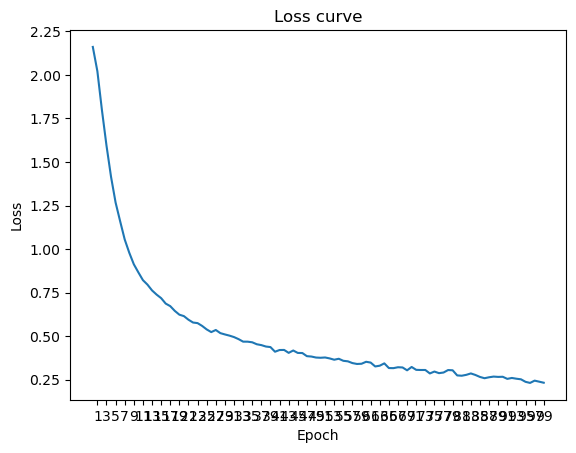

In [13]:
train_model(model=model, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, data=train_loader)

In [14]:
evaluate(model, test_loader) #91.6

Accuracy auf den Testdatensatz 88.08%


In [15]:
torch.save(model.state_dict(), './models/torchCNN.pth')